In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import keras.backend as K
import ast
!pip install pyisopach 
import pyisopach

n_points=1000
noise_level=0.05
masse_min, masse_max = 0, 1000


Fonctions pour générer les données

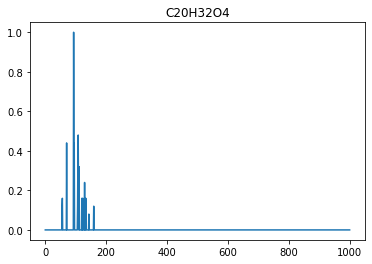

In [ ]:
# Données réelles
# max n : 29098

def sample_dataset(n):

  MSdata = pd.read_csv('MSdata.csv', encoding='mac_roman')
  sample=MSdata.sample(n=n).reset_index(drop=True)

  X, Y = np.empty((n,n_points)), np.empty((n,n_points))

  for i in range(n):
    Signal0=np.zeros((n_points))
    peaks = ast.literal_eval(str(sample['peak'][i]).replace("'",""))
    intensites = ast.literal_eval(str(sample['intensitÈ'][i]).replace("'",""))
    for k in range(len(peaks)) :
      if peaks[k]<masse_max:
        Signal0[n_points*int(peaks[k])//(masse_max-masse_min)]=intensites[k]/max(intensites)
    
    Y[i]=Signal0
        
    Signal1=Signal0+np.random.normal(0,noise_level,size=(n_points))
    X[i]=Signal1
        
  return(X, Y)


i=290


MSdata = pd.read_csv('MSdata.csv', encoding='mac_roman')
Signal0=np.zeros((n_points))
peaks = ast.literal_eval(str(MSdata['peak'][i]).replace("'",""))
intensites = ast.literal_eval(str(MSdata['intensitÈ'][i]).replace("'",""))
for k in range(len(peaks)) :
  if peaks[k]<masse_max:
    Signal0[n_points*int(peaks[k])//(masse_max-masse_min)]=intensites[k]/max(intensites)

Masse=np.linspace(masse_min, masse_max, n_points)
plt.plot(Masse,Signal0)
plt.title(MSdata['Formule chimique'][i])
plt.savefig("c20h32o4.png")
plt.show()


/usr/local/lib/python3.7/dist-packages/pyisopach/molecule.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(weights), np.array(ratios)


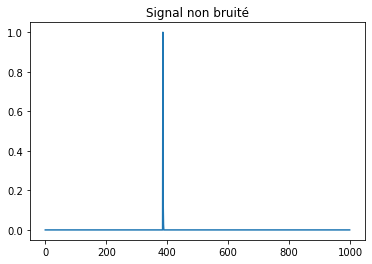

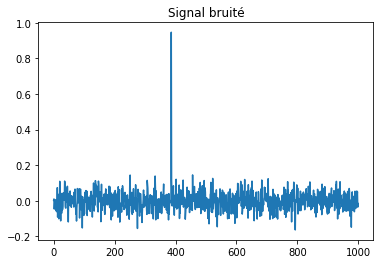

In [ ]:
# pyisopach

def pyiso_dataset(n):

  X, Y = np.empty((n,n_points)), np.empty((n,n_points))
  Masse=np.linspace(masse_min, masse_max, n_points)

  for _ in range(n):

    Signal0=np.zeros((n_points))

    n_c=np.random.randint(1, 20)
    n_o=np.random.randint(1, 20)
    n_h=np.random.randint(1, 40)

    mol = pyisopach.Molecule("C"+str(n_c)+"H"+str(n_h)+"O"+str(n_o))
    locs, sizes = mol.isotopic_distribution()

    for i in range(len(locs)):
      if n_points*locs[i]//(masse_max-masse_min) < masse_max :
        Signal0[int(n_points*locs[i]//(masse_max-masse_min))]=sizes[i]/100

    Y[_]=Signal0

    Signal1=Signal0+np.random.normal(0,noise_level,size=(n_points))
    X[_]=Signal1
        
  return(X, Y)


X, Y = pyiso_dataset(2)
plt.plot(Y[0])
plt.title("Signal non bruité")
plt.show()
plt.plot(X[0])
plt.title("Signal bruité")
plt.show()

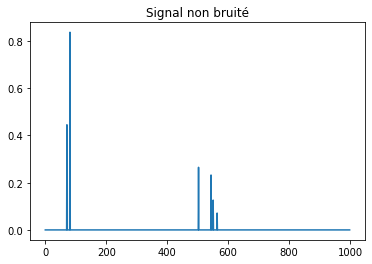

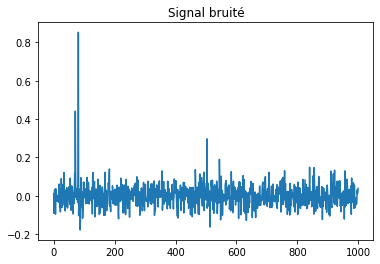

In [ ]:
#Données simulées

def generate_dataset(n) :
    
    X, Y = np.zeros((n,n_points), dtype=np.float32), np.zeros((n,n_points), dtype=np.float32)
    
    for _ in range(n) :
        
        Signal0=np.zeros((n_points), dtype=np.float32)
        n_gros_pics=np.random.poisson(lam=2)
        
        for k in range(n_gros_pics):
            #pic du milieu
            loc=int(np.random.exponential(scale=(masse_min+masse_max)/2, size=1))
            if loc<masse_max :
              Signal0[n_points*loc//(masse_max-masse_min)]=np.random.uniform(0.2,1)
              #pics autour
              n_petits_pics_gauche=np.random.poisson()
              n_petits_pics_droite=np.random.poisson()
              for i in range(1,n_petits_pics_gauche+1):
                  noise=np.random.normal(0,1)
                  if round(n_points*loc/(masse_max-masse_min)+noise)-10*i>0:
                      Signal0[round(n_points*loc/(masse_max-masse_min)+noise)-10*i]=min(5*Signal0[n_points*loc//(masse_max-masse_min)]/(10*i),1)+np.random.normal(0,0.02)
              for j in range(1,n_petits_pics_droite+1):
                  noise=np.random.normal(0,1)
                  if round(n_points*loc/(masse_max-masse_min)+noise)+10*j<n_points:
                      Signal0[round(n_points*loc/(masse_max-masse_min)+noise)+10*j]=min(5*Signal0[n_points*loc//(masse_max-masse_min)]/(10*j),1)+np.random.normal(0,0.02)
        
        Y[_]=Signal0

        Signal1=Signal0+np.random.normal(0,noise_level,size=(n_points))
        X[_]=Signal1
        
    return(X, Y)

X, Y = generate_dataset(2)
plt.plot(Y[1])
plt.title("Signal non bruité")
plt.show()
plt.plot(X[1])
plt.title("Signal bruité")
plt.show()

In [ ]:
#nombre de spectres pour entraîner
n=10000

X_train_sample, Y_train_sample = sample_dataset(n)
X_train_pyiso, Y_train_pyiso = pyiso_dataset(n)
X_train_generate, Y_train_generate = generate_dataset(n)


X_train_sample = X_train_sample.reshape(X_train_sample.shape[0], X_train_sample.shape[1], 1)
X_train_pyiso = X_train_pyiso.reshape(X_train_pyiso.shape[0], X_train_pyiso.shape[1], 1)
X_train_generate = X_train_generate.reshape(X_train_generate.shape[0], X_train_generate.shape[1], 1)

input_shape=X_train_sample.shape[1:]

/usr/local/lib/python3.7/dist-packages/pyisopach/molecule.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(weights), np.array(ratios)


Création et entrainement des modèles

In [ ]:
def customloss(y_true, y_pred) :
  penalty_coef=1
  mse = K.sum(K.square(y_pred-y_true))
  penalty = K.mean(K.square(y_pred))
  return mse+penalty_coef*penalty

In [ ]:
#%% MassBank
model_sample=models.Sequential()
model_sample.add(layers.Dense(300, activation='relu', input_shape=input_shape))
model_sample.add(layers.Dropout(0.2))
model_sample.add(layers.Dense(300, activation='relu'))
model_sample.add(layers.Dropout(0.2))
model_sample.add(layers.Dense(300, activation='relu'))
model_sample.add(layers.Dropout(0.2))
model_sample.add(layers.Dense(300, activation='relu'))
model_sample.add(layers.Dropout(0.2))
model_sample.add(layers.Dense(1))
model_sample.add(layers.Dropout(0.2))
model_sample.add(layers.Flatten())

model_sample.compile(optimizer='rmsprop', loss=customloss, metrics=['mse'])
model_sample.fit(X_train_sample, Y_train_sample, batch_size=16, epochs=3, validation_split=0.2)

Epoch 1/3
500/500 [==============================] - 9s 12ms/step - loss: 10.7310 - mse: 6.7060e-04 - val_loss: 3.4031 - val_mse: 2.1264e-04
Epoch 2/3
500/500 [==============================] - 5s 11ms/step - loss: 7.1613 - mse: 4.4750e-04 - val_loss: 2.6146 - val_mse: 1.6335e-04
Epoch 3/3
500/500 [==============================] - 5s 11ms/step - loss: 6.8667 - mse: 4.2909e-04 - val_loss: 3.9208 - val_mse: 2.4500e-04


In [ ]:
#%% Pyiso
model_pyiso=models.Sequential()
model_pyiso.add(layers.Dense(450, activation='relu', input_shape=input_shape))
model_pyiso.add(layers.Dropout(0.2))
model_pyiso.add(layers.Dense(150, activation='relu'))
model_pyiso.add(layers.Dropout(0.2))
model_pyiso.add(layers.Dense(100, activation='relu'))
model_pyiso.add(layers.Dropout(0.2))
model_pyiso.add(layers.Dense(1))
model_pyiso.add(layers.Dropout(0.2))
model_pyiso.add(layers.Flatten())

model_pyiso.compile(optimizer='adam', loss=customloss, metrics=['mse'])
model_pyiso.fit(X_train_pyiso, Y_train_pyiso, batch_size=16, epochs=3, validation_split=0.2)

Epoch 1/3
500/500 [==============================] - 4s 7ms/step - loss: 4.3559 - mse: 2.7219e-04 - val_loss: 0.8861 - val_mse: 5.5343e-05
Epoch 2/3
500/500 [==============================] - 3s 6ms/step - loss: 3.7925 - mse: 2.3698e-04 - val_loss: 1.1140 - val_mse: 6.9586e-05
Epoch 3/3
500/500 [==============================] - 3s 6ms/step - loss: 3.5912 - mse: 2.2440e-04 - val_loss: 0.9036 - val_mse: 5.6438e-05


In [ ]:
#%% Génération aléatoire
model_generate=models.Sequential()
model_generate.add(layers.Dense(500, activation='relu', input_shape=input_shape))
model_generate.add(layers.Dropout(0.2))
model_generate.add(layers.Dense(500, activation='relu'))
model_generate.add(layers.Dropout(0.2))
model_generate.add(layers.Dense(500, activation='relu'))
model_generate.add(layers.Dropout(0.2))
model_generate.add(layers.Dense(1))
model_generate.add(layers.Dropout(0.2))
model_generate.add(layers.Flatten())

model_generate.compile(optimizer='adam', loss=customloss, metrics=['mse'])
model_generate.fit(X_train_generate, Y_train_generate, batch_size=16, epochs=5, validation_split=0.2)

Epoch 1/5
500/500 [==============================] - 8s 14ms/step - loss: 4.3619 - mse: 2.7257e-04 - val_loss: 1.2006 - val_mse: 7.5000e-05
Epoch 2/5
500/500 [==============================] - 7s 14ms/step - loss: 3.5583 - mse: 2.2235e-04 - val_loss: 1.0715 - val_mse: 6.6932e-05
Epoch 3/5
500/500 [==============================] - 7s 14ms/step - loss: 3.7489 - mse: 2.3426e-04 - val_loss: 1.1945 - val_mse: 7.4621e-05
Epoch 4/5
500/500 [==============================] - 7s 14ms/step - loss: 3.7622 - mse: 2.3509e-04 - val_loss: 1.0648 - val_mse: 6.6511e-05
Epoch 5/5
500/500 [==============================] - 7s 14ms/step - loss: 3.6729 - mse: 2.2951e-04 - val_loss: 1.2401 - val_mse: 7.7469e-05


Evaluation sur les données MassBank sans renormalisation

In [ ]:
from keras.metrics import mean_squared_error

X_test, Y_test = sample_dataset(10000)

Y_seuil = np.where(Y_test<0.3, 0, Y_test)
print("mse sur l'ensemble de test de la méthode 'seuillage' : ", np.mean(mean_squared_error(Y_seuil,Y_test)))

loss, mse = model_sample.evaluate(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), Y_test, batch_size=16, verbose=0)
print("mse sur l'ensemble de test de la méthode 'sample' : ", mse)
loss, mse = model_pyiso.evaluate(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), Y_test, batch_size=16, verbose=0)
print("mse sur l'ensemble de test de la méthode 'pyiso' : ", mse)
loss, mse = model_generate.evaluate(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), Y_test, batch_size=16, verbose=0)
print("mse sur l'ensemble de test de la méthode 'generate' : ", mse)

mse sur l'ensemble de test de la méthode 'seuillage' :  0.00017025898223721795
mse sur l'ensemble de test de la méthode 'sample' :  0.00024721119552850723
mse sur l'ensemble de test de la méthode 'pyiso' :  0.00017151431529782712
mse sur l'ensemble de test de la méthode 'generate' :  0.000173709646333009


Evaluation sur les données MassBank avec renormalisation

In [ ]:
Y_seuil = np.where(Y_test<0.3, 0, Y_test)
print("mse sur l'ensemble de test de la méthode 'seuillage' : ", np.mean(mean_squared_error(Y_seuil,Y_test)))

Y_pred_sample = model_sample.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
for i in range(n):
  Y_pred_sample[i] = Y_pred_sample[i]/max(Y_pred_sample[i])
print("mse sur l'ensemble de test de la méthode 'sample' renormalisée : ", np.mean(mean_squared_error(Y_test, Y_pred_sample)))

Y_pred_pyiso = model_pyiso.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
for i in range(n):
  Y_pred_pyiso[i] = Y_pred_pyiso[i]/max(Y_pred_pyiso[i])
print("mse sur l'ensemble de test de la méthode 'pyiso' renormalisée : ", np.mean(mean_squared_error(Y_test, Y_pred_pyiso)))

Y_pred_generate = model_generate.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))
for i in range(n):
  Y_pred_generate[i] = Y_pred_generate[i]/max(Y_pred_generate[i])
print("mse sur l'ensemble de test de la méthode 'generate' renormalisée : ", np.mean(mean_squared_error(Y_test, Y_pred_generate)))


mse sur l'ensemble de test de la méthode 'seuillage' :  0.00017025898223721795
mse sur l'ensemble de test de la méthode 'sample' renormalisée :  0.0001922993
mse sur l'ensemble de test de la méthode 'pyiso' renormalisée :  0.00038731948
mse sur l'ensemble de test de la méthode 'generate' renormalisée :  0.00051319017


Quelques exemples

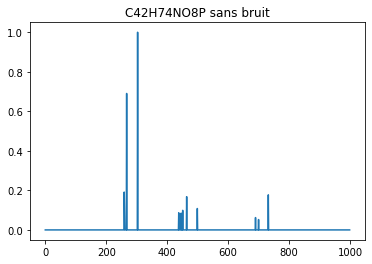

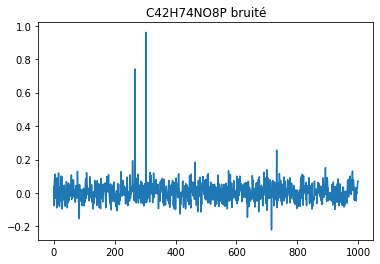

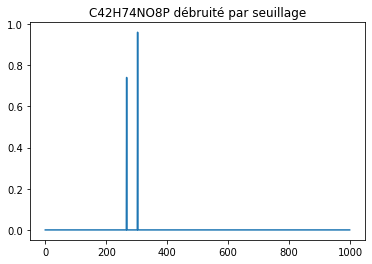

mse =  0.00015078467816059823


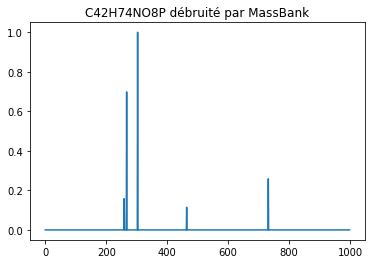

mse =  6.0858787037432194e-05


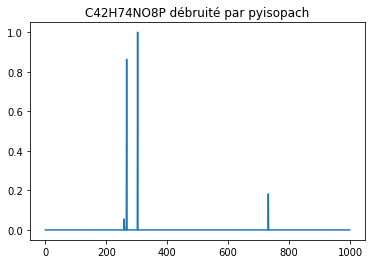

mse =  0.00012707588030025363


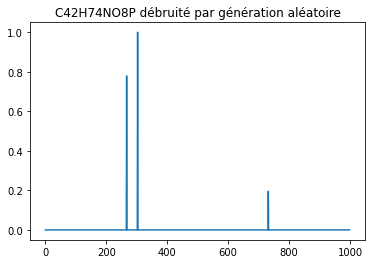

mse =  0.0001234121882589534


In [ ]:
index = 799

MSdata = pd.read_csv('MSdata.csv', encoding='mac_roman')
X, Y = np.zeros((n_points)), np.zeros((n_points))

name = MSdata['Formule chimique'][index]
peaks = ast.literal_eval(str(MSdata['peak'][index]).replace("'",""))
intensites = ast.literal_eval(str(MSdata['intensitÈ'][index]).replace("'",""))
for k in range(len(peaks)) :
  if peaks[k]<masse_max:
    Y[n_points*int(peaks[k])//(masse_max-masse_min)]=intensites[k]/max(intensites)
        
X=Y+np.random.normal(0,noise_level,size=(n_points))

plt.plot(Y)
plt.title(name+" sans bruit")
plt.savefig(name+"_sans_bruit.jpg")
plt.show()


plt.plot(X)
plt.title(name+" bruité")
plt.savefig(name+"bruit.jpg")
plt.show()


Y_seuil = np.where(X<0.3, 0, X)
plt.plot(Y_seuil)
plt.title(name +" débruité par seuillage")
plt.savefig(name+"_seuillage.jpg")
plt.show()
print('mse = ', float(mean_squared_error(Y, Y_seuil)))

Y_pred_sample = model_sample.predict(X)
Y_pred_sample = Y_pred_sample/max(Y_pred_sample)
Y_pred_sample = np.where(Y_pred_sample<0.05, 0, Y_pred_sample)
plt.plot(Y_pred_sample)
plt.title(name+" débruité par MassBank")
plt.savefig(name+"_massbank.jpg")
plt.show()
print('mse = ', float(mean_squared_error(Y, Y_pred_sample.flatten())))

Y_pred_pyiso = model_pyiso.predict(X)
Y_pred_pyiso = Y_pred_pyiso/max(Y_pred_pyiso)
Y_pred_pyiso = np.where(Y_pred_pyiso<0.05, 0, Y_pred_pyiso)
plt.plot(Y_pred_pyiso)
plt.title(name+" débruité par pyisopach")
plt.savefig(name+"_pyiso.jpg")
plt.show()
print('mse = ', float(mean_squared_error(Y, Y_pred_pyiso.flatten())))

Y_pred_generate = model_generate.predict(X)
Y_pred_generate = Y_pred_generate/max(Y_pred_generate)
Y_pred_generate = np.where(Y_pred_generate<0.15, 0, Y_pred_generate)
plt.plot(Y_pred_generate)
plt.title(name+" débruité par génération aléatoire")
plt.savefig(name+"_generation.jpg")
plt.show()
print('mse = ', float(mean_squared_error(Y, Y_pred_generate.flatten())))